In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from ruptures import Pelt
import warnings
warnings.filterwarnings('ignore')

In [63]:
import pandas as pd
import glob

# Get a list of all XLSX files in the current directory
file_list = glob.glob('../data/*.xlsx')

# Create an empty list to store DataFrames
df_list = []

# Check if there are any XLSX files found
if not file_list:
  print("No XLSX files found in the current directory.")
else:
  # Read each XLSX file into a DataFrame and append to the list (if not empty)
  for file in file_list:
      try:
          df = pd.read_excel(file)
          df_list.append(df)
      except FileNotFoundError:
          print(f"File not found: {file}")

# Only proceed with concatenation if there are DataFrames in the list
if df_list:
  # Concatenate all DataFrames into a single DataFrame
  df = pd.concat(df_list, ignore_index=True)

display(df.head())

,Trade Date,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton)
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-02,WYKQ2,BG,2004.0,"1,175.00",0.00,"1,175.00","1,175.00",0.0,0.0,28.29
3,2012-01-03,WYKQ2,BG,2004.0,"1,175.00",0.00,"1,175.00","1,175.00",0.0,0.0,10.80
4,2012-01-04,WYKQ2,BG,2004.0,"1,180.00",0.00,"1,180.00","1,180.00",0.0,0.0,6.61


In [64]:
display(df.columns)
display(df.info())

Index(['Trade Date', 'Symbol', 'Warehouse', 'Production Year', 'Opening Price',
       'Closing Price', 'High', 'Low', 'Change', 'Persetntage Change',
       'Volume (Ton)'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91439 entries, 0 to 91438
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Trade Date          91423 non-null  datetime64[ns]
 1   Symbol              91423 non-null  object        
 2   Warehouse           91423 non-null  object        
 3   Production Year     91423 non-null  float64       
 4   Opening Price       91423 non-null  object        
 5   Closing Price       91423 non-null  object        
 6   High                91423 non-null  object        
 7   Low                 91423 non-null  object        
 8   Change              91423 non-null  float64       
 9   Persetntage Change  91423 non-null  object        
 10  Volume (Ton)        91423 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 7.7+ MB


None

In [65]:
display(df.describe())

,Trade Date,Production Year,Change,Volume (Ton)
count,91423,91423.000000,91423.000000,91423.000000
mean,2016-01-27 10:51:25.691784448,2007.398106,24.979907,22.745432
min,2012-01-02 00:00:00,2002.000000,0.000000,1.800000
25%,2014-02-19 00:00:00,2005.000000,0.000000,6.830000
50%,2016-02-29 00:00:00,2007.000000,10.000000,12.750000
75%,2018-02-13 00:00:00,2009.000000,29.000000,25.500000
max,2019-09-13 00:00:00,2011.000000,2230.000000,596.700000
std,NaN,2.366144,58.014626,29.990070


In [66]:
# Reset the index to make 'Date' a column again
df.reset_index(inplace=True)

# Convert columns to float where possible
for column in df.columns:
    try:
        df[column] = df[column].str.replace(',', '').astype(float)
    except (ValueError, AttributeError):
        continue

# Convert 'Trade Date' to datetime and clean the data
df['Trade Date'] = pd.to_datetime(df['Trade Date'], errors='coerce')
df = df.dropna(subset=['Trade Date'])
df = df.sort_values(by='Trade Date')
df = df.rename(columns={'Trade Date': 'Date'})
df.reset_index(drop=True, inplace=True)

# Ensure there are no missing values
df = df.dropna()

# Set 'Date' as the index again
df.set_index('Date', inplace=True)


In [67]:
display(df.head())
display(df.tail())

,index,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton)
Date,,,,,,,,,,,
2012-01-02,2,WYKQ2,BG,2004.0,1175.0,0.0,1175.0,1175.0,0.0,0.0,28.29
2012-01-02,1340,WSDA3,HW,2004.0,1380.0,0.0,1380.0,1375.0,0.0,0.0,48.60
2012-01-02,3658,ULK6,GM,2003.0,1270.0,0.0,1270.0,1270.0,0.0,0.0,17.85
2012-01-02,1565,WLMAQ2,JM,2004.0,1250.0,0.0,1250.0,1250.0,0.0,0.0,10.80
2012-01-02,881,WSDB3,DL,2004.0,1300.0,0.0,1305.0,1300.0,0.0,0.0,21.61


,index,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton)
Date,,,,,,,,,,,
2019-09-13,86791,UHRA4,DD,2011.0,2480.0,2480.0,2480.0,2480.0,0.0,0.0%,10.20
2019-09-13,86507,UHRB4,DD,2011.0,2200.0,2200.0,2200.0,2200.0,15.0,0.0%,5.10
2019-09-13,88038,UGJ3,HW,2011.0,1575.0,1575.0,1575.0,1575.0,25.0,1.0%,5.10
2019-09-13,82269,WGM3,GM,2011.0,1061.0,1061.0,1061.0,1061.0,0.0,0.0,8.01
2019-09-13,90273,LWBP2,SC,2010.0,1353.0,1353.0,1353.0,1353.0,5.0,0.0%,10.20


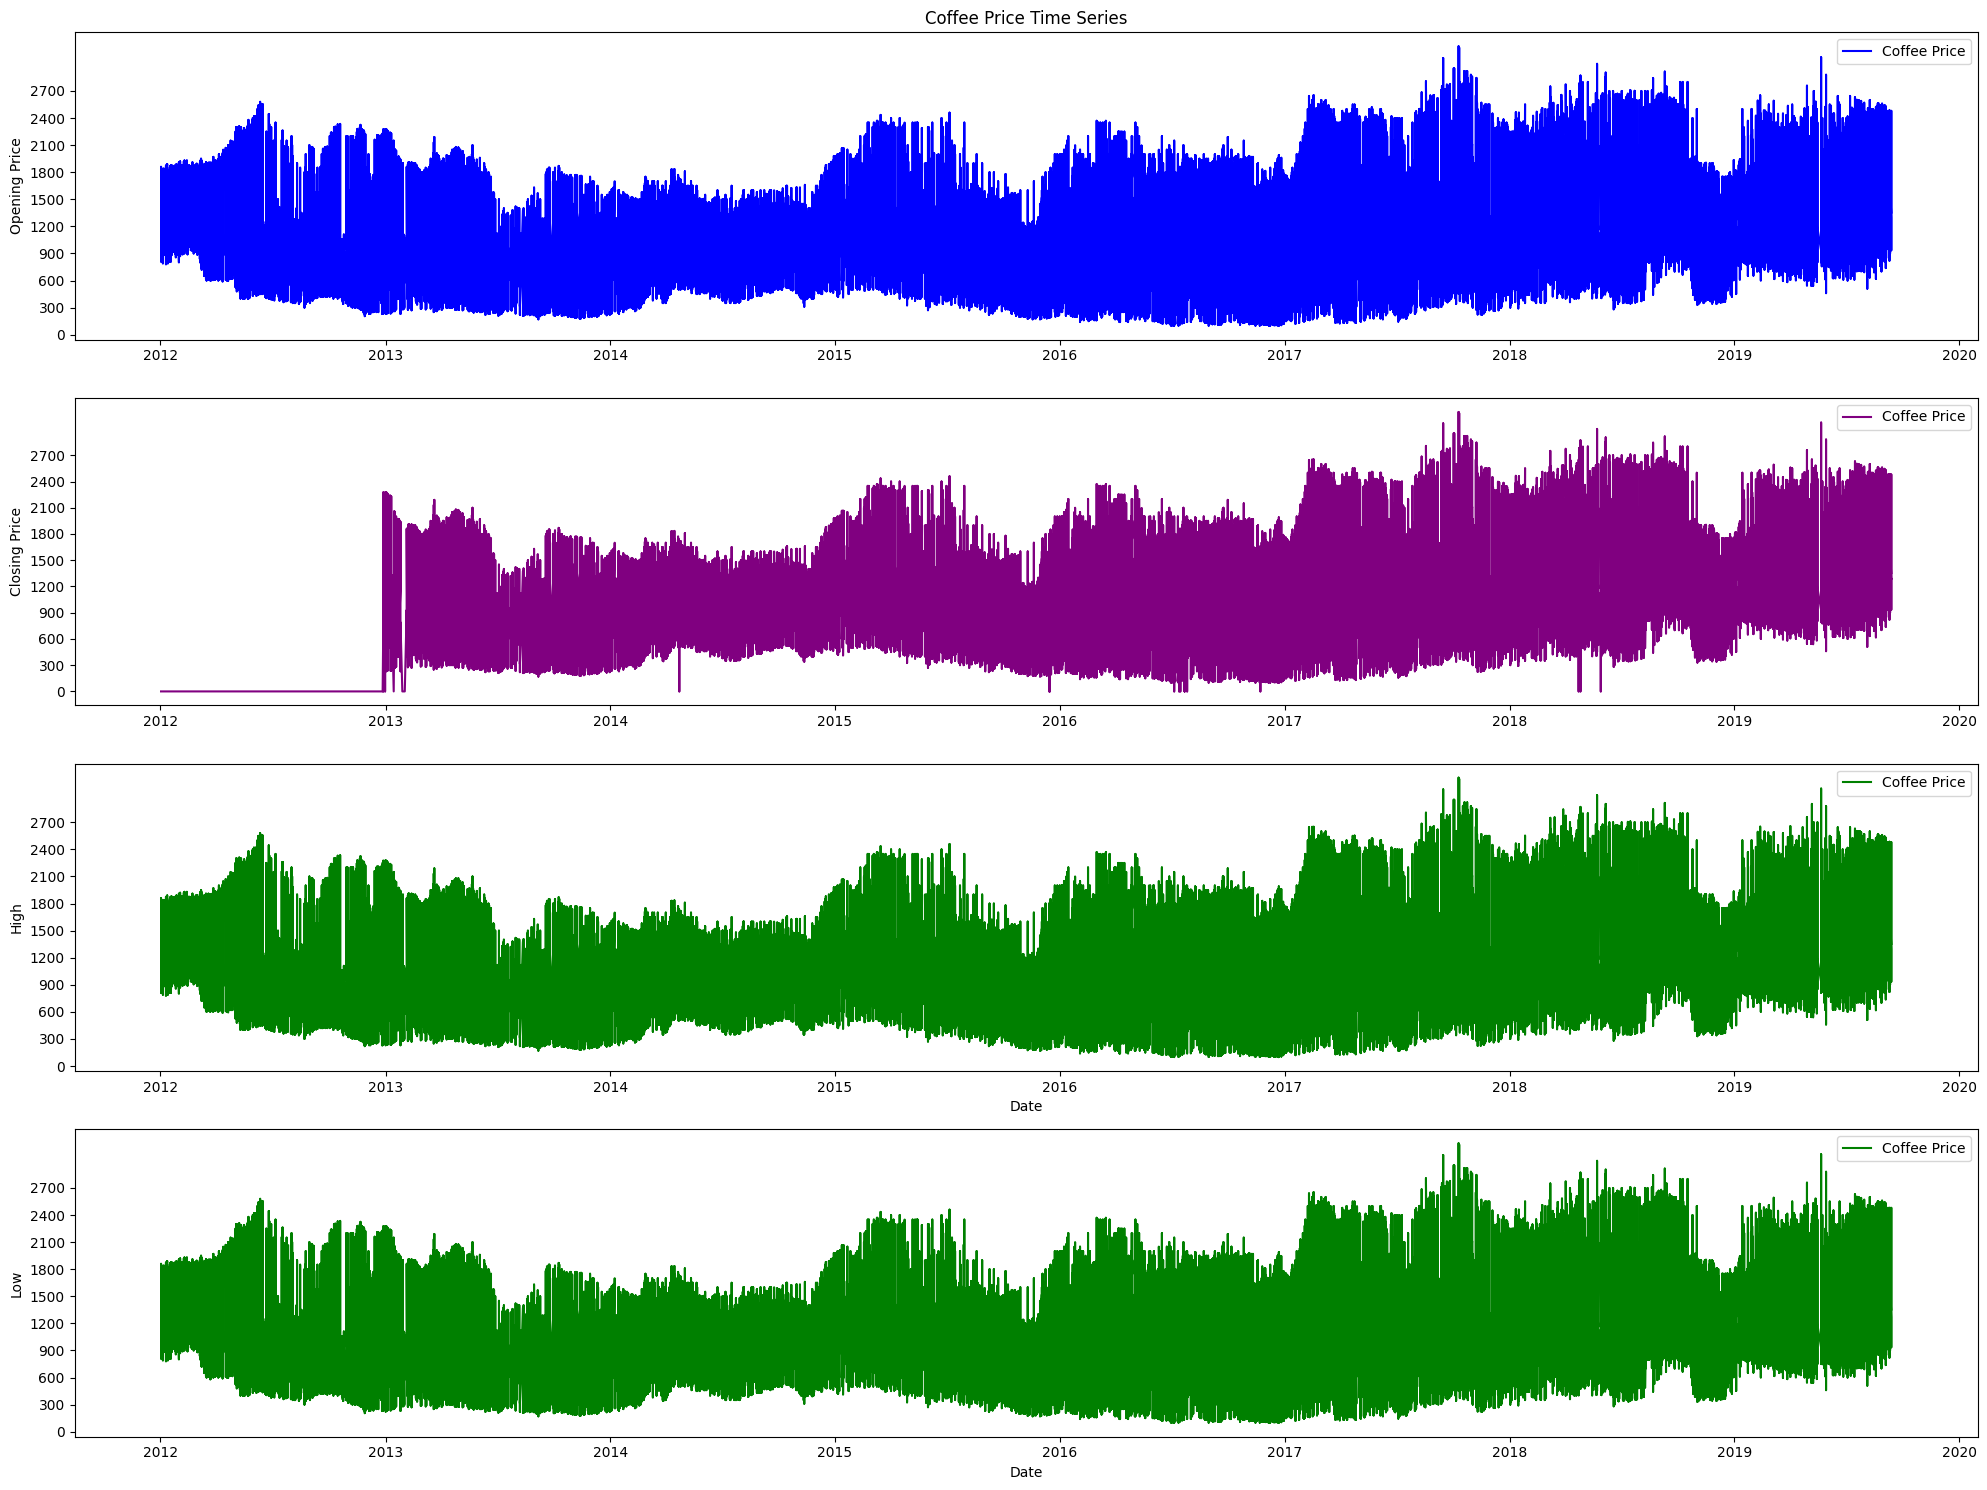

In [68]:
import matplotlib.pyplot as plt
import numpy as np
def plot_time_series(df):
    
    plt.figure(figsize=(20, 15))
    
    # Plot Price
    plt.subplot(4, 1, 1)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['Opening Price'], color='blue', label='Coffee Price')
    plt.title("Coffee Price Time Series")
    plt.ylabel("Opening Price")
    plt.legend()

    # Plot Closing price
    plt.subplot(4, 1, 2)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['Closing Price'], color='purple', label='Coffee Price')
    plt.ylabel("Closing Price")
    plt.legend()
    
    # Plot High
    plt.subplot(4, 1, 3)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['High'], color='green', label='Coffee Price')
    plt.xlabel("Date")
    plt.ylabel("High")
    plt.legend()

        # Plot Low
    plt.subplot(4, 1, 4)
    plt.yticks(np.arange(0, 3000, step=300))
    plt.plot(df.index, df['Low'], color='green', label='Coffee Price')
    plt.xlabel("Date")
    plt.ylabel("Low")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
 
plot_time_series(df)

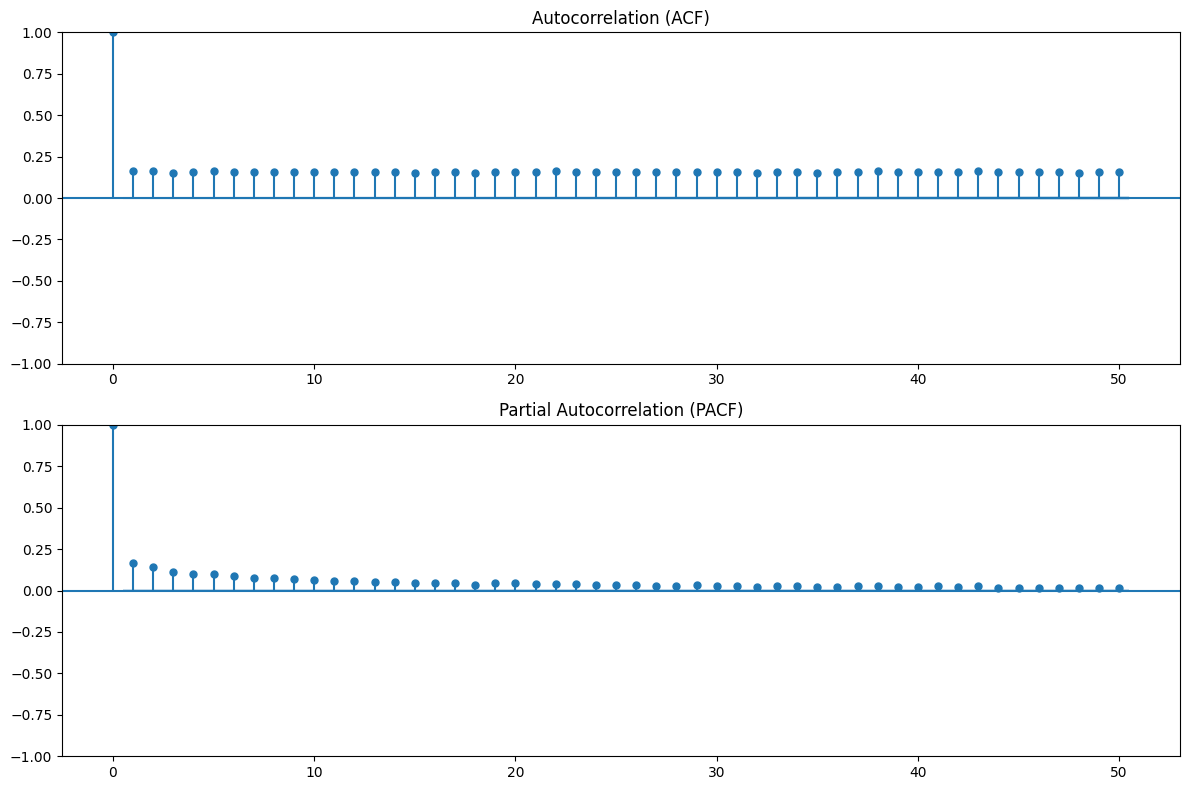

In [69]:
def plot_acf_pacf(df, column='Opening Price'):
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df[column], ax=ax[0])
    plot_pacf(df[column], ax=ax[1])
    ax[0].set_title("Autocorrelation (ACF)")
    ax[1].set_title("Partial Autocorrelation (PACF)")
    plt.tight_layout()
    plt.show()





plot_acf_pacf(df)

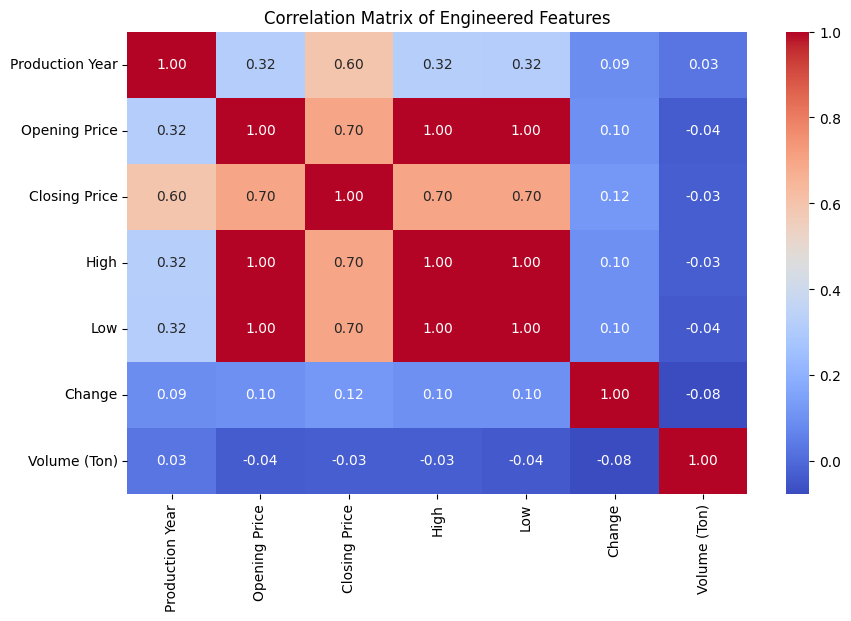

In [70]:
def correlation_analysis(df):
    # Select only float columns
    float_df = df.select_dtypes(include=['float64'])
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(float_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Engineered Features")
    plt.show()

correlation_analysis(df)

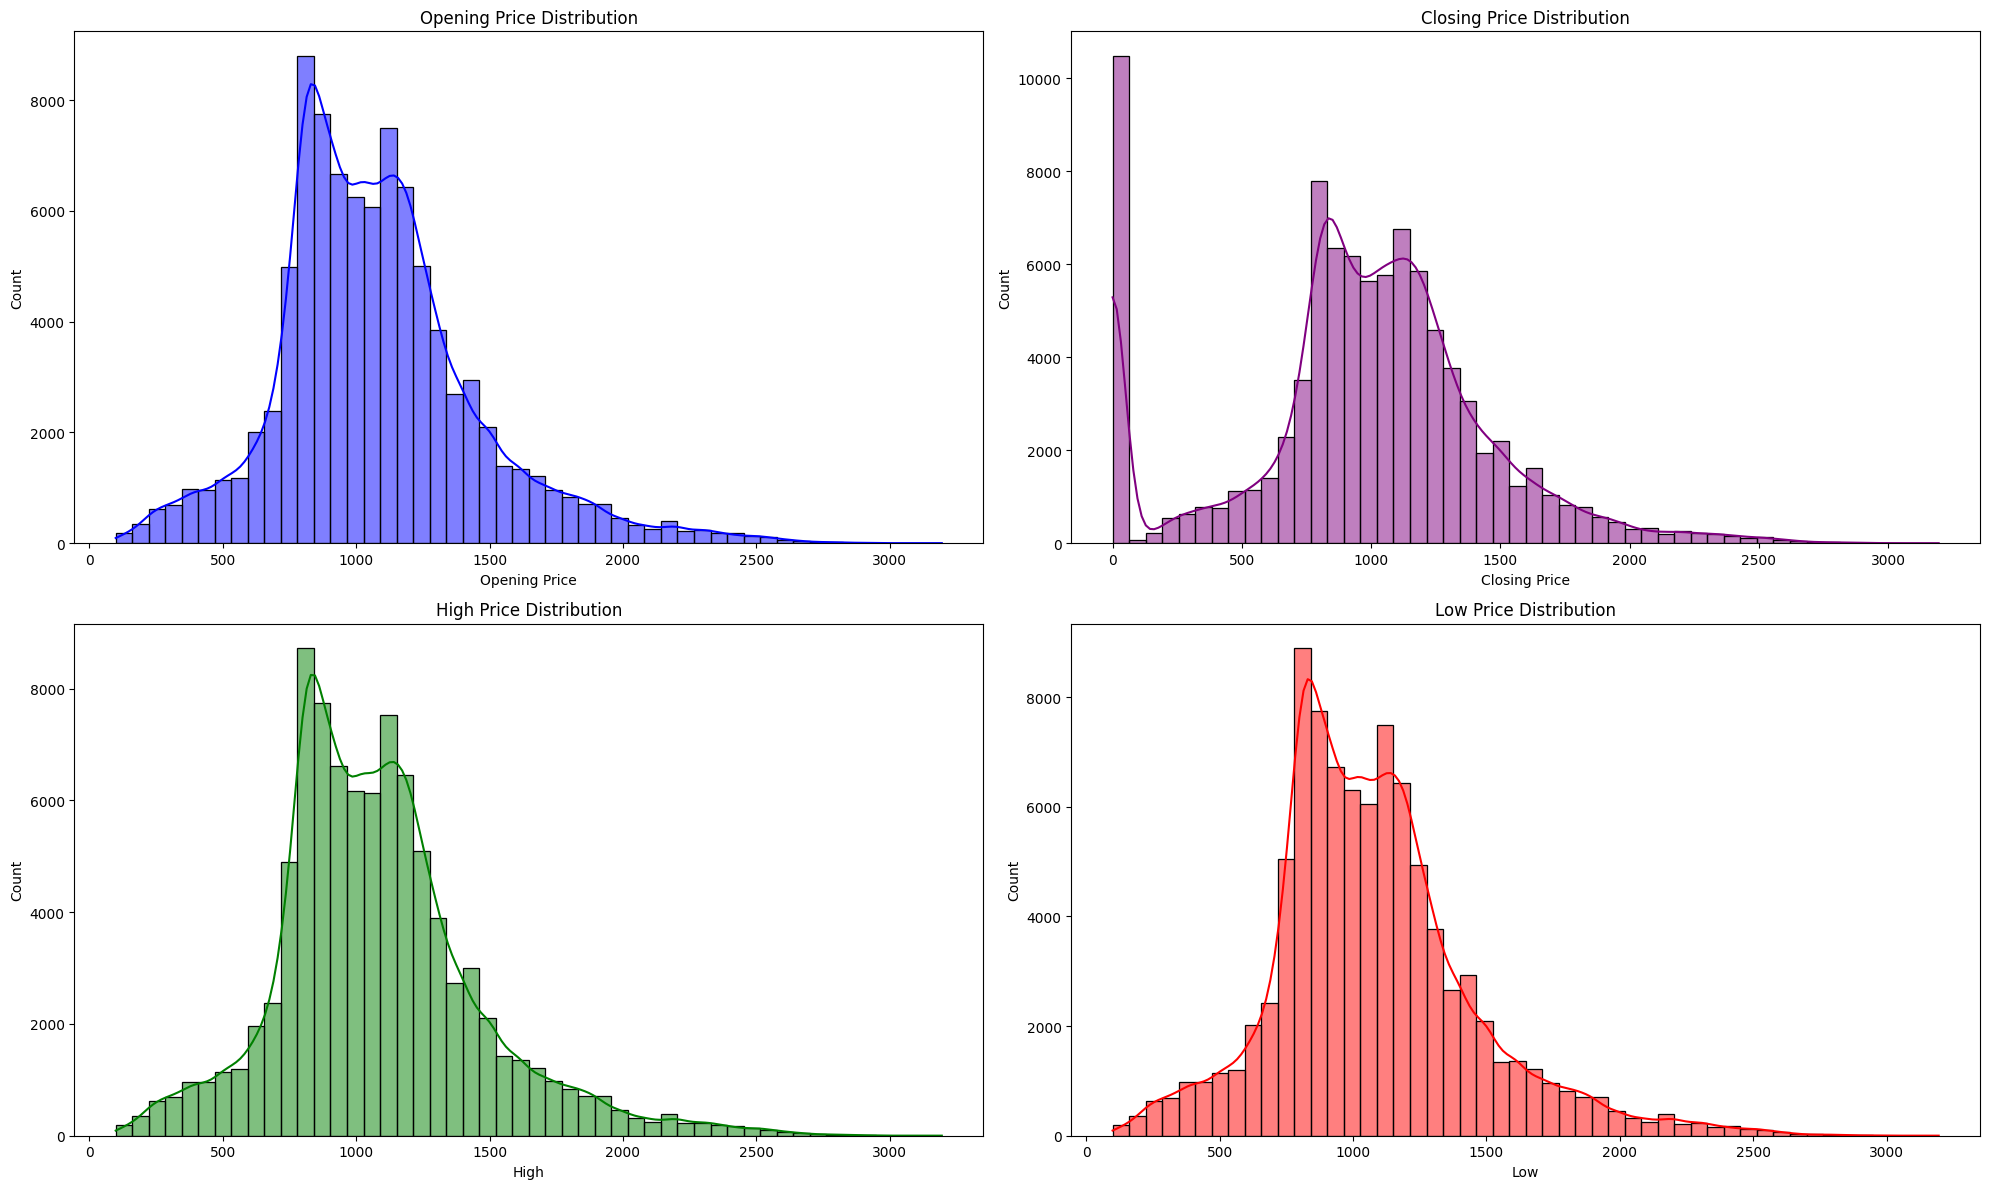

In [71]:
# Distribution Analysis
def distribution_analysis(df):
    
    plt.figure(figsize=(20, 12))
    
    # Opening Price Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(df['Opening Price'], bins=50, color='blue', kde=True)
    plt.title("Opening Price Distribution")

    # Closing Price Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(df['Closing Price'], bins=50, color='purple', kde=True)
    plt.title("Closing Price Distribution")
    
    # High Price Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(df['High'], bins=50, color='green', kde=True)
    plt.title("High Price Distribution")
    
    # Low Price Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(df['Low'], bins=50, color='red', kde=True)
    plt.title("Low Price Distribution")
    
    plt.tight_layout()
    plt.show()

distribution_analysis(df)

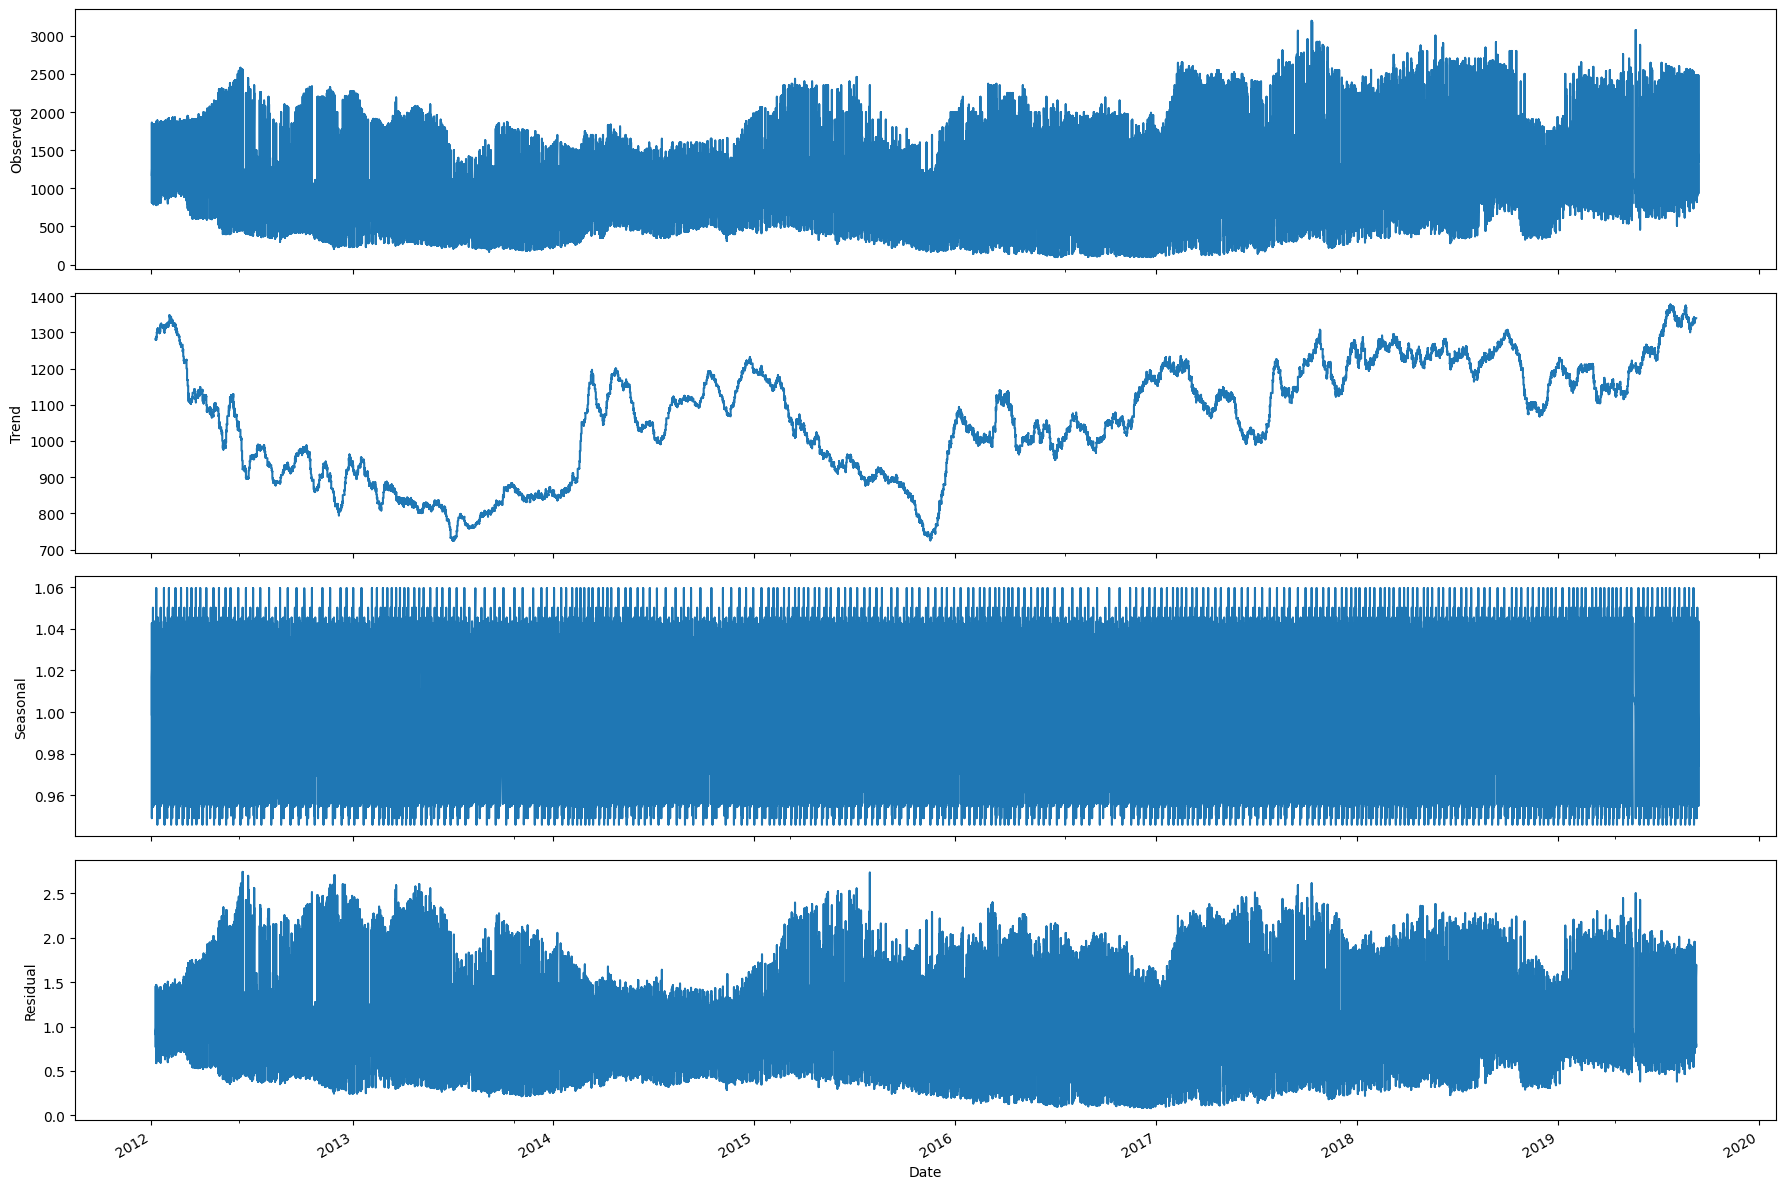

In [72]:
# Seasonality Analysis
def seasonality_analysis(df):
   
    decomposition = seasonal_decompose(df['Opening Price'], model='multiplicative', period=365)

    # Set up a wider figure
    fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
    
    # Plot each component with wider axes
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()

seasonality_analysis(df)

In [73]:
# Calculate Returns
df['Returns'] = df['Closing Price'].pct_change()
df = df.dropna()
# Risk Metrics Calculation
def calculate_risk_metrics(df, confidence_level=0.05):
    var = np.percentile(df['Returns'].dropna(), 100 * confidence_level)
    es = df['Returns'][df['Returns'] <= var].mean()
    
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var:.4f}")
    print(f"Expected Shortfall (ES) at {confidence_level*100}% confidence level: {es:.4f}")

calculate_risk_metrics(df)

Value at Risk (VaR) at 5.0% confidence level: -0.5660
Expected Shortfall (ES) at 5.0% confidence level: -0.6815


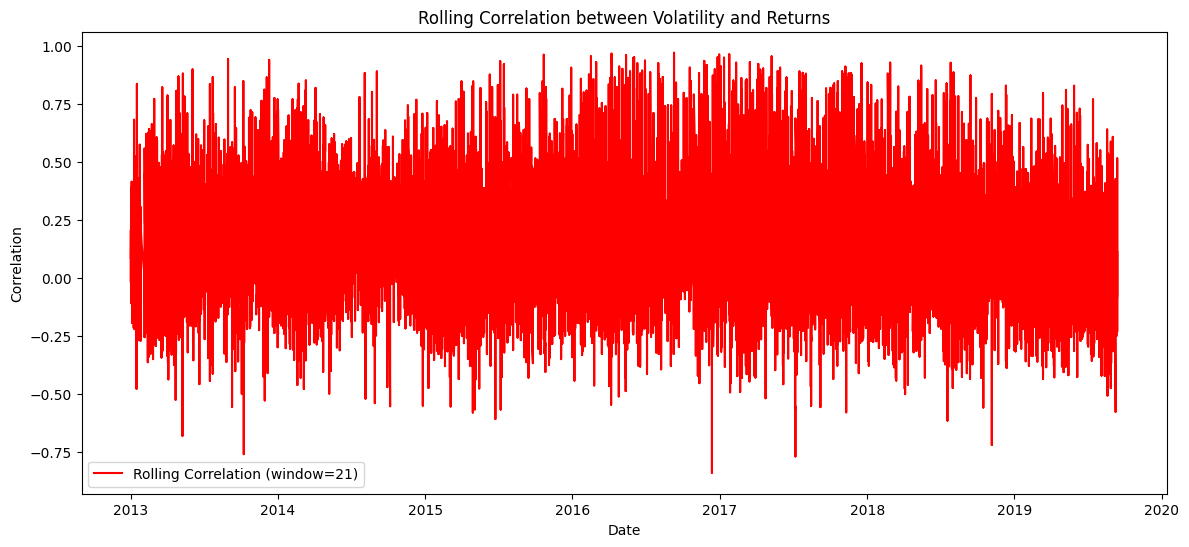

In [74]:
# Calculate Volatility if it doesn't exist
if 'Volatility' not in df.columns:
    df['Volatility'] = df['Returns'].rolling(window=21).std()
    df.dropna(inplace=True)

# Rolling Correlation
def rolling_correlation(df, window=21):
    df['Rolling_Corr'] = df['Volatility'].rolling(window).corr(df['Returns'])
    
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Rolling_Corr'], color='red', label=f'Rolling Correlation (window={window})')
    plt.title("Rolling Correlation between Volatility and Returns")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.legend()
    plt.show()

rolling_correlation(df)


In [75]:
def check_stationarity(df, column='Closing Price'):
    result = adfuller(df[column])
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary. Differencing may be needed.")

# Summary statistics
print("Descriptive statistics of Closing Price:")
display(df['Closing Price'].describe())
check_stationarity(df)


Descriptive statistics of Closing Price:


count    80395.000000
mean      1080.569215
std        380.535491
min          0.000000
25%        830.000000
50%       1050.000000
75%       1265.000000
max       3195.000000
Name: Closing Price, dtype: float64

ADF Statistic: -9.488644274033518
p-value: 3.703726651053981e-16
The data is stationary.


In [76]:
# Event Data Preparation
def create_event_dataframe():
    """
    Create a DataFrame for significant events related to oil price changes.
    """
    events_data = [
    {"Date": "1987-10-19", "Event": "Black Monday", "Type": "Economic"},
    {"Date": "1988-07-03", "Event": "USS Vincennes Incident (Iran Air Flight 655)", "Type": "Geopolitical"},
    {"Date": "1989-01-01", "Event": "End of Cold War", "Type": "Geopolitical"},
    {"Date": "1990-08-02", "Event": "Iraq Invades Kuwait", "Type": "Geopolitical"},
    {"Date": "1990-08-06", "Event": "U.N. Sanctions on Iraq", "Type": "Geopolitical"},
    {"Date": "1991-01-17", "Event": "Gulf War", "Type": "Geopolitical"},
    {"Date": "1991-12-26", "Event": "Collapse of the Soviet Union", "Type": "Geopolitical"},
    {"Date": "1993-01-01", "Event": "North Sea Oil Production Expansion", "Type": "Supply"},
    {"Date": "1993-03-27", "Event": "OPEC Agreement to Cut Production", "Type": "OPEC"},
    {"Date": "1996-04-30", "Event": "Sanctions on Libya", "Type": "Geopolitical"},
    {"Date": "1997-01-01", "Event": "Asian Financial Crisis", "Type": "Economic"},
    {"Date": "1998-01-01", "Event": "Venezuela’s Political Crisis", "Type": "Geopolitical"},
    {"Date": "1998-12-31", "Event": "BP-Amoco Merger", "Type": "Industry"},
    {"Date": "1999-03-24", "Event": "NATO Bombing of Yugoslavia", "Type": "Geopolitical"},
    {"Date": "2000-03-01", "Event": "OPEC Price Band Mechanism", "Type": "OPEC"},
    {"Date": "2000-09-28", "Event": "Second Intifada", "Type": "Geopolitical"},
    {"Date": "2001-09-11", "Event": "September 11 Attacks", "Type": "Geopolitical"},
    {"Date": "2002-01-01", "Event": "Iraq-U.S. Tensions", "Type": "Geopolitical"},
    {"Date": "2003-03-20", "Event": "U.S. Invasion of Iraq", "Type": "Geopolitical"},
    {"Date": "2003-01-01", "Event": "ChevronTexaco Merger", "Type": "Industry"},
    {"Date": "2004-01-01", "Event": "Rising Demand from China", "Type": "Demand"},
    {"Date": "2005-08-01", "Event": "Hurricane Katrina", "Type": "Natural Disaster"},
    {"Date": "2005-01-01", "Event": "China’s Strategic Oil Reserves", "Type": "Demand"},
    {"Date": "2006-01-01", "Event": "Niger Delta Militants", "Type": "Geopolitical"},
    {"Date": "2007-01-01", "Event": "Baku-Tbilisi-Ceyhan Pipeline Completion", "Type": "Supply"},
    {"Date": "2008-01-01", "Event": "Global Financial Crisis", "Type": "Economic"},
    {"Date": "2008-01-01", "Event": "U.S. Dollar Devaluation", "Type": "Economic"},
    {"Date": "2010-04-20", "Event": "Deepwater Horizon Oil Spill", "Type": "Natural Disaster"},
    {"Date": "2010-01-01", "Event": "Russia Expands Energy Ties with China", "Type": "Industry"},
    {"Date": "2011-01-01", "Event": "Arab Spring", "Type": "Geopolitical"},
    {"Date": "2011-03-11", "Event": "Japanese Earthquake and Fukushima Disaster", "Type": "Natural Disaster"},
    {"Date": "2012-01-01", "Event": "Sanctions on Iran", "Type": "Geopolitical"},
    {"Date": "2012-01-01", "Event": "Saudi Arabia’s Increased Production", "Type": "Supply"},
    {"Date": "2013-01-01", "Event": "North American Shale Boom", "Type": "Supply"},
    {"Date": "2014-02-01", "Event": "Russia-Ukraine Conflict", "Type": "Geopolitical"},
    {"Date": "2014-06-01", "Event": "Oil Price Collapse", "Type": "Economic"},
    {"Date": "2015-01-01", "Event": "China’s Economic Slowdown", "Type": "Economic"},
    {"Date": "2016-05-01", "Event": "Canadian Wildfires", "Type": "Natural Disaster"},
    {"Date": "2017-01-01", "Event": "U.S. Oil Exports to Asia", "Type": "Industry"},
    {"Date": "2018-01-01", "Event": "Turkey-U.S. Sanctions", "Type": "Geopolitical"},
    {"Date": "2019-01-01", "Event": "U.S.-China Trade War", "Type": "Economic"},
    {"Date": "2020-01-01", "Event": "COVID-19 Pandemic", "Type": "Global Crisis"},
    {"Date": "2020-03-01", "Event": "OPEC+ Price War", "Type": "OPEC"},
    {"Date": "2020-04-01", "Event": "Oil Storage Crisis", "Type": "Supply"},
    {"Date": "2021-02-01", "Event": "Texas Winter Storm", "Type": "Natural Disaster"},
    {"Date": "2021-01-01", "Event": "Global Supply Chain Disruptions", "Type": "Economic"},
    {"Date": "2021-12-01", "Event": "Omicron Variant Emergence", "Type": "Global Crisis"},
    {"Date": "2022-02-24", "Event": "Russia-Ukraine War", "Type": "Geopolitical"},
    {"Date": "2022-09-26", "Event": "Nord Stream Pipeline Explosions", "Type": "Geopolitical"},
    {"Date": "2022-11-01", "Event": "G7 Oil Price Cap on Russian Exports", "Type": "Economic"},
    {"Date": "2023-07-01", "Event": "Saudi-Russia Oil Cuts", "Type": "OPEC"},
    {"Date": "2023-01-01", "Event": "China’s Post-COVID Economic Recovery", "Type": "Demand"}
]
    
    events_df = pd.DataFrame(events_data)
    events_df['Date'] = pd.to_datetime(events_df['Date'])
    return events_df

In [77]:
# Event Data Preparation
def create_event_dataframe():
    """
    Create a DataFrame for significant events related to oil price changes.
    """
     # Annotate events on the plot
    events_data = [
            {"Date": "2012-09-01", "event": "Global coffee surplus led to a decline in international prices, affecting Ethiopian coffee exports."},
            {"Date": "2012-11-15", "event": "Ethiopian Birr depreciation increased export competitiveness but reduced farmers' real earnings."},
            {"Date": "2013-03-10", "event": "Erratic weather patterns reported in coffee regions like Oromia and Sidama due to climate change."},
            {"Date": "2013-06-25", "event": "Traceability programs introduced to certify the authenticity of Ethiopian coffee, boosting its market reputation."},
            {"Date": "2014-02-05", "event": "Droughts in major coffee regions disrupted production, reducing supply and potentially increasing prices."},
            {"Date": "2014-06-20", "event": "Ethiopian coffee production threatened by fungal diseases such as Coffee Leaf Rust due to changing weather patterns."},
            {"Date": "2014-08-12", "event": "Specialty coffee demand increased globally, improving premium pricing for Ethiopian coffee."},
            {"Date": "2015-04-15", "event": "El Niño effects led to inconsistent rainfall, negatively impacting Ethiopian coffee yields."},
            {"Date": "2015-07-10", "event": "New agreements signed with the European Union to promote Ethiopian specialty coffee exports."},
            {"Date": "2015-11-20", "event": "Strengthened coffee cooperatives began helping farmers secure better prices."},
            {"Date": "2016-06-30", "event": "Civil unrest in Oromia disrupted coffee production and logistics, affecting exports."},
            {"Date": "2016-08-15", "event": "Ethiopia hosted the World Coffee Conference, boosting global awareness of its coffee industry."},
            {"Date": "2016-09-10", "event": "Global coffee prices reached record lows due to oversupply, heavily affecting Ethiopian farmers."},
            {"Date": "2017-01-20", "event": "Introduction of new coffee varieties resistant to climate change began in Ethiopia, aiming to sustain production."},
            {"Date": "2017-05-25", "event": "Ethiopian coffee exporters faced stricter global quality standards, requiring additional investments in processing."},
            {"Date": "2017-10-11", "event": "The Ethiopian government devalued the Birr by 15%, boosting exports but increasing import costs for farm inputs."},
            {"Date": "2017-12-01", "event": "Specialty coffee demand continued growing, providing a premium market for Ethiopian coffee."},
            {"Date": "2018-02-15", "event": "Coffee farmers protested low prices and unfair trade practices, leading to calls for supply chain reforms."},
            {"Date": "2018-07-01", "event": "Political reforms under PM Abiy Ahmed improved optimism for better trade practices in the coffee sector."},
            {"Date": "2018-08-30", "event": "Ethiopia joined the International Coffee Agreement, aiming to enhance its coffee market competitiveness."},
            {"Date": "2018-10-25", "event": "Ethiopia signed agreements to increase coffee exports to China, opening new market opportunities."},
            {"Date": "2019-01-20", "event": "Global concerns over climate change raised discussions on protecting Ethiopian coffee from extinction by 2080."},
            {"Date": "2019-05-01", "event": "The Ethiopian Coffee and Tea Authority announced initiatives to increase coffee export volumes."},
            {"Date": "2019-06-10", "event": "Farmers reported declining yields due to unpredictable rainfall patterns."},
            {"Date": "2019-08-15", "event": "Sidama autonomy referendum caused temporary disruption in coffee production and logistics."},
        ]

    
    events_df = pd.DataFrame(events_data)
    events_df['date'] = pd.to_datetime(events_df['Date'])
    events_df['date'] = pd.to_datetime(events_df['date'])
    return events_df

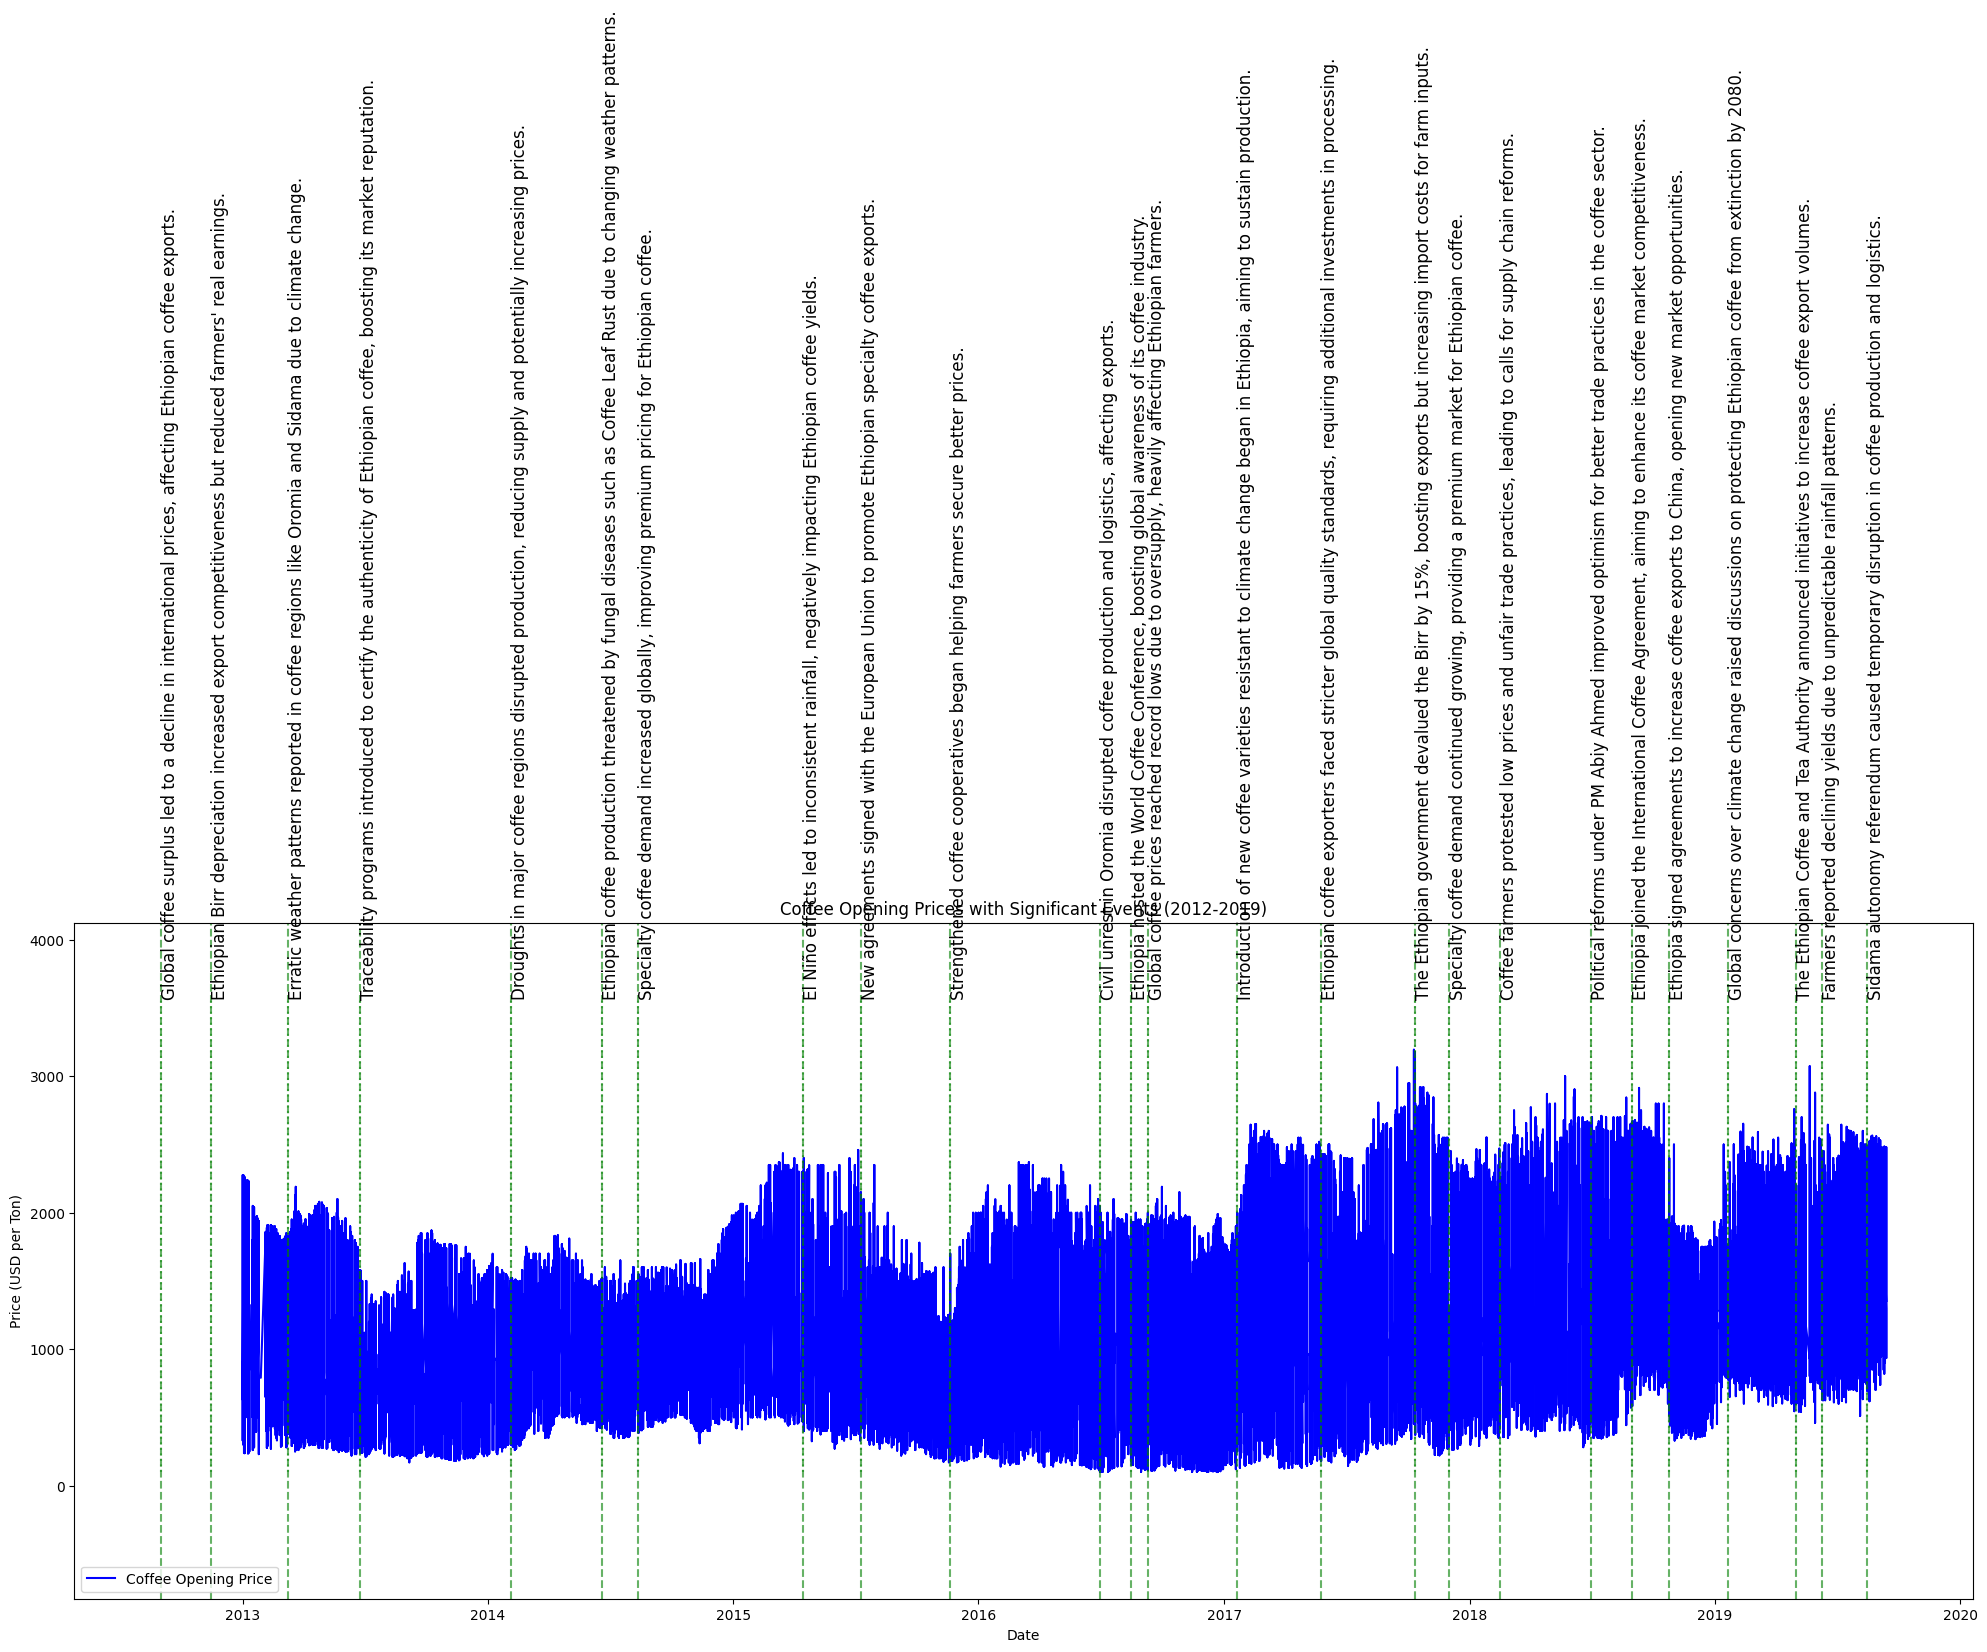

In [78]:
def plot_with_events(df, events_df):
    # Ensure 'date' column in events_df is in datetime format
    events_df['date'] = pd.to_datetime(events_df['date'])
    
    plt.figure(figsize=(20, 16))  # Increase the height to make the graph taller
    plt.plot(df.index, df['Opening Price'], label='Coffee Opening Price', color='blue')
    
    y_max = df['Opening Price'].max()
    y_min = df['Opening Price'].min()

    # Add padding to the y-axis for space above and below
    y_padding = (y_max - y_min) * 0.3  # 30% padding for more vertical space
    plt.ylim(y_min - y_padding, y_max + y_padding)

    for _, row in events_df.iterrows():
        event_date = row['date']
        event_text = row['event']
        
        # Add a vertical line at the event date
        plt.axvline(event_date, color='green', linestyle='--', alpha=0.6)

        # Add horizontal line connecting text to the event line
        text_y = y_max + y_padding * 0.4  # Place the text above the graph
        plt.plot([event_date, event_date], [y_min, text_y], color='green', linestyle=':', alpha=0.5)
        
        # Place event text slightly above the graph
        plt.text(event_date, text_y, event_text, rotation=90, verticalalignment='bottom', fontsize=12, color='black')
    
    plt.title("Coffee Opening Prices with Significant Events (2012-2019)")
    plt.xlabel("Date")
    plt.ylabel("Price (USD per Ton)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming `events_df` is created using `create_event_dataframe`
events_df = create_event_dataframe()
plot_with_events(df, events_df)


In [79]:
# Event Impact on Volatility and Returns
def event_impact_analysis(df, events_df):
    impacts = []
    for _, event in events_df.iterrows():
        date = event['date']
        # Define a window around the event date
        before = df.loc[date - pd.Timedelta(days=5):date - pd.Timedelta(days=1)]
        after = df.loc[date:date + pd.Timedelta(days=5)]
        
        # Calculate average volatility and returns before and after the event
        before_volatility = before['Volatility'].mean()
        after_volatility = after['Volatility'].mean()
        before_return = before['Returns'].mean()
        after_return = after['Returns'].mean()
        
        # Calculate average prices before and after the event
        before_opening_price = before['Opening Price'].mean()
        after_opening_price = after['Opening Price'].mean()
        before_closing_price = before['Closing Price'].mean()
        after_closing_price = after['Closing Price'].mean()
        before_high_price = before['High'].mean()
        after_high_price = after['High'].mean()
        
        impacts.append({
            "Event": event['event'],
            "Date": date,
            "Before_Opening_Price": before_opening_price,
            "After_Opening_Price": after_opening_price,
            "Before_Closing_Price": before_closing_price,
            "After_Closing_Price": after_closing_price,
            "Before_High_Price": before_high_price,
            "After_High_Price": after_high_price,
            "Before_Volatility": before_volatility,
            "After_Volatility": after_volatility,
            "Before_Return": before_return,
            "After_Return": after_return,
        })
    
    impact_df = pd.DataFrame(impacts)
    print("Event Impact Analysis:")
    display(impact_df)
    return impact_df

# Event Impact Analysis
impact_df = event_impact_analysis(df, events_df)



Event Impact Analysis:


,Event,Date,Before_Opening_Price,After_Opening_Price,Before_Closing_Price,After_Closing_Price,Before_High_Price,After_High_Price,Before_Volatility,After_Volatility,Before_Return,After_Return
0,Global coffee surplus led to a decline in inte...,2012-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ethiopian Birr depreciation increased export c...,2012-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Erratic weather patterns reported in coffee re...,2013-03-10,858.602362,868.643917,858.507874,868.347181,859.413386,869.554896,0.493546,0.423166,0.106029,0.070416
3,Traceability programs introduced to certify th...,2013-06-25,823.037879,746.276316,822.886364,746.125000,823.416667,746.585526,0.417350,0.602278,0.076967,0.138956
4,Droughts in major coffee regions disrupted pro...,2014-02-05,881.722222,919.032110,882.171717,919.146789,883.020202,920.912844,0.412510,0.486506,0.075622,0.094343
5,Ethiopian coffee production threatened by fung...,2014-06-20,1035.225989,1062.945783,1035.062147,1063.746988,1035.819209,1065.325301,0.469774,0.473551,0.095401,0.079897
6,"Specialty coffee demand increased globally, im...",2014-08-12,1060.952381,1086.072000,1061.333333,1086.192000,1061.964286,1086.832000,0.436540,0.419895,0.076862,0.076111
7,"El Niño effects led to inconsistent rainfall, ...",2015-04-15,977.946429,996.063348,977.508929,995.547511,978.392857,996.601810,0.367382,0.389907,0.059928,0.059469
8,New agreements signed with the European Union ...,2015-07-10,933.846154,927.132948,933.792899,926.936416,934.278107,927.832370,0.665212,0.526553,0.147151,0.114769
9,Strengthened coffee cooperatives began helping...,2015-11-20,765.223776,745.228395,765.769231,745.339506,766.496503,746.561728,0.745536,0.845575,0.204208,0.184644


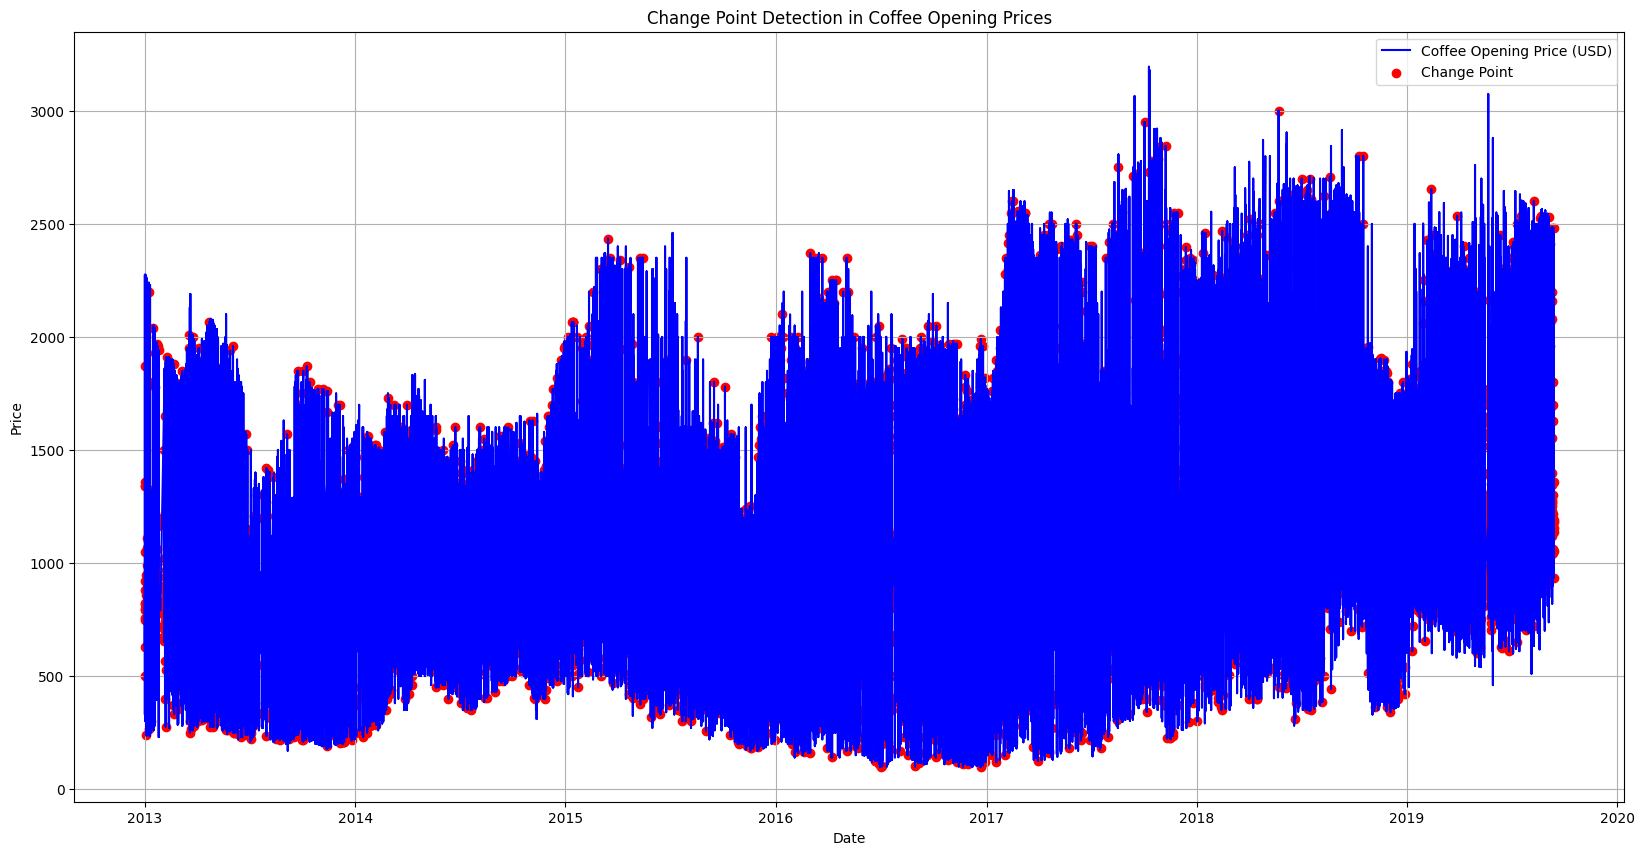

In [80]:
# Prepare the price data for change point detection
price_values = df['Opening Price'].values

# Apply PELT to detect change points in the series
algo = Pelt(model="l2").fit(price_values)
change_points = algo.predict(pen=10)  # Adjust penalty to tune sensitivity

# Plot Coffee Opening Price with detected change points highlighted
plt.figure(figsize=(20, 10))  # Increase width and decrease height
plt.plot(df.index, df['Opening Price'], label='Coffee Opening Price (USD)', color='blue')
plt.scatter(df.index[change_points[:-1]], df['Opening Price'].iloc[change_points[:-1]], color='red', label='Change Point')
plt.legend()
plt.title('Change Point Detection in Coffee Opening Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [81]:
df.to_csv("../data/preproccessed_coffee_prices.csv", index=True)
display(df.head())

,index,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton),Returns,Volatility,Rolling_Corr
Date,,,,,,,,,,,,,,
2013-01-01,11118,WSDB4,HW,2005.0,900.0,900.0,900.0,900.0,0.0,0.0,14.40,0.098901,0.776352,NaN
2013-01-01,20260,LUBP5B,SC,2003.0,330.0,330.0,330.0,330.0,0.0,0.0,10.20,-0.633333,0.793819,NaN
2013-01-01,20275,LUBP5A,SC,2003.0,440.0,436.0,440.0,430.0,0.0,0.0,24.79,0.321212,0.794552,NaN
2013-01-01,17835,UFRAUG,BG,2004.0,660.0,660.0,660.0,660.0,25.0,3.0%,15.30,0.513761,0.794644,NaN
2013-01-01,12663,UYCB6,DL,2004.0,910.0,910.0,910.0,910.0,0.0,0.0,8.11,0.378788,0.777047,NaN
